#Hello World in commplax

## Install dependencies (expand sub-cell to see details)

### Install [JAX](https://github.com/google/jax)

In [1]:
!pip install --upgrade pip
# Jaxlib-GPU binary is hosted in Google's repo
!pip install --upgrade jax jaxlib==0.1.61+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

     |████████████████████████████████| 1.5MB 6.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 155.7 MB 14 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.62+cuda110
    Uninstalling jaxlib-0.1.62+cuda110:
      Successfully uninstalled jaxlib-0.1.62+cuda110


### Install [Commplax](https://github.com/remifan/commplax)

In [2]:
!pip install https://github.com/remifan/commplax/archive/master.zip

     \ 163 kB 1.7 MB/s
  Created wheel for commplax: filename=commplax-1.0-py3-none-any.whl size=27683 sha256=5ba00f71029b95488965a21683c68768ede5c7f2adb3de4e459f5dbb7be521a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-wfs8yx4a/wheels/25/14/4f/4c257e023cb69b9083db46dfd8962dfe801086c4b321465742
  Created wheel for quantumrandom: filename=quantumrandom-1.9.0-py3-none-any.whl size=9131 sha256=58408c873ce03de68db6f0644923e2c77812fbafe3c2d8a84e7b1b9f2eb06707
  Stored in directory: /root/.cache/pip/wheels/99/08/4f/618080011e884de267d956ba1e96144f1071417dd75f480de4
Successfully built commplax quantumrandom


## Download transmission data

In [3]:
!wget https://commplax-data.s3-ap-southeast-1.amazonaws.com/data.mat

--2021-03-16 06:57:46--  https://commplax-data.s3-ap-southeast-1.amazonaws.com/data.mat
Resolving commplax-data.s3-ap-southeast-1.amazonaws.com (commplax-data.s3-ap-southeast-1.amazonaws.com)... 52.219.36.159
Connecting to commplax-data.s3-ap-southeast-1.amazonaws.com (commplax-data.s3-ap-southeast-1.amazonaws.com)|52.219.36.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114097864 (109M) [application/x-www-form-urlencoded]
Saving to: ‘data.mat’

data.mat            100%[===================>] 108.81M  12.3MB/s    in 10s     

2021-03-16 06:57:57 (10.6 MB/s) - ‘data.mat’ saved [114097864/114097864]



## Demodulate DP-16QAM ~815km SSMF transmission signal using commplax

In [4]:
import jax
from jax import numpy as jnp
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from commplax import xop, comm, xcomm, adaptive_filter as af, plot as cplt

In [5]:
# load downloaded example dataset
dat = spio.loadmat('data', squeeze_me=True)

# In commplax, signal has shape (N, D) where N is time axis and D is dimention
# axis(e.g. D=2 for dual polarizaiton if each pol. is complex valued).
y = dat['recv']
x = dat['sent']
sr = dat['sample_rate']
br = dat['baud_rate']
lp = dat['launched_power']
dist = dat['distance']
spans = dat['spans']

# meta data
print('shape of y: %s (preprocessed waveforms, resampled to 2 samples/symbol): ' % str(y.shape))
print('shape of x: %s (sent symbols, emulating PDM by delaying 1 polarization): ' % str(x.shape))
print('sample rate: %.1f GHz' % (sr / 1e9))
print('baud rate: %.1f GBd' % (br / 1e9))
print('launched power: %.3f W' % (lp))
print('link distance: %.1f km (measured)' % (dist / 1e3))
print('number of spans: %d' % spans)

shape of y: (3500000, 2) (preprocessed waveforms, resampled to 2 samples/symbol): 
shape of x: (65536, 2) (sent symbols, emulating PDM by delaying 1 polarization): 
sample rate: 56.0 GHz
baud rate: 28.0 GBd
launched power: 0.001 W
link distance: 815.0 km (measured)
number of spans: 10


In [7]:
# mesuare CD using FrFT-based algorithms
# first time run could be slightly slow to warmup GPU

CD = xcomm.measure_cd(y[10000:30000, 0], sr, bins=2000)[0] / dist
print('estimated CD = %.4g s/m^2' % CD)

estimated CD = 1.669e-05 s/m^2


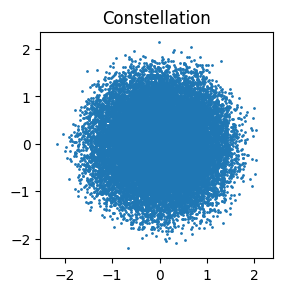

In [8]:
# 1 step/span time domain digital back propogation

D_fir_taps = 301 # number of taps for CD compensation operator (namely D op.)
_, param_D, param_N = comm.dbp_params(sr, dist/spans, spans, D_fir_taps, fiber_dispersion=CD)
y_dbp = xcomm.dbp_timedomain(y / jnp.sqrt(2), param_D, 0.5 * lp * param_N) * jnp.sqrt(2)

# scatterplot X-Pol signal to compared with the ones shown below
cplt.scatter(y_dbp[1000000:1020000, 0])

In [9]:
# make adaptive filters' functonal utilies
cma_init, cma_update, cma_map = af.cma()
rde_init, rde_update, rde_map = af.rde()
# create 2-cpr AF array with each cpr module implemented dimention(pol.)-wise 
cpr_init, cpr_update, cpr_map = af.array(af.cpane_ekf, 2)()

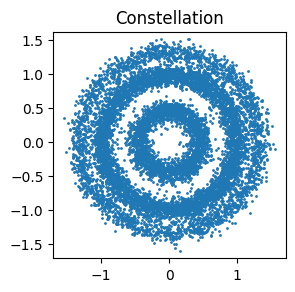

In [10]:
taps = 19  # MIMO filter tap number
sps = 2  # T/2-spaced adaptive equalizer

# framing signal to enable map function
yf = jnp.array(xop.frame(y_dbp, taps, sps))

# get initial weights
w0 = cma_init(taps=19)
# warm-up MIMO via CMA using a short sequence
w, _ = af.iterate(cma_update, w0, yf[:20000])
# switch to RDE that inherits CMA'weights (with anti-singularity modification)
w0 = rde_init(w, unitarize=True)
w, (rde_loss, ws) = af.iterate(rde_update, w0, yf)
# map to get MIMO out
x_hat = rde_map(ws, yf)

cplt.scatter(x_hat[500000:510000, 1])

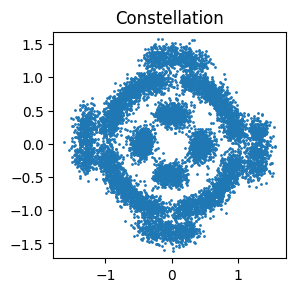

In [11]:
# Frequency-offset coarse compensation using simple 4th-power-fft-max method
fo, fo_metric = xcomm.foe_mpowfftmax(x_hat[100000:200000], M=4)
fo = jnp.mean(fo) # average estimated FO from X and Y pol.
T = jnp.arange(len(x_hat))
x_hat *= jnp.tile(jnp.exp(-1j * fo * T)[:, None], (1, 2))

cplt.scatter(x_hat[500000:510000, 0])

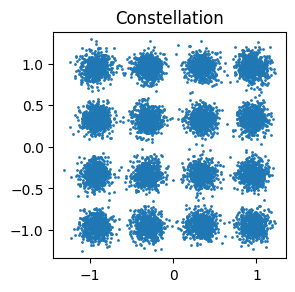

In [12]:
# residual FO removal, carrier phase recovery via 1-tap CPANE-EKF
cpr_state = cpr_init()
cpr_update, (phi, cpr_decision) = af.iterate(cpr_update, cpr_state, x_hat)
x_hat = cpr_map(phi, x_hat)

# scatterplot signal after this stage
cplt.scatter(x_hat[500000:510000, 0])

X/Y delay from PDME: 409


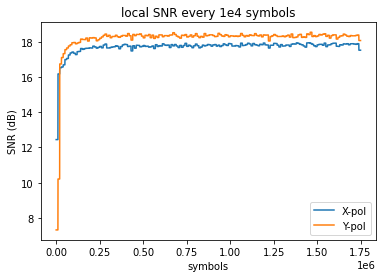

,BER,QSq,SNR
dim0,0.000236,10.872773,17.795842
dim1,0.000129,11.257363,18.338173
total,0.000182,11.040345,18.058548


In [13]:
# synchronize sent symbols
z, d = comm.align_periodic(x_hat, x, begin=100000)
print("X/Y delay from PDME: %d" % (d[0]-d[1]))
# remove phase ambiguity and rescale signal
x_hat = xcomm.cpe(x_hat, z) * jnp.sqrt(10)

# check DSP convergence
snr_local = comm.qamqot_local(x_hat, z)['SNR'][:, :2]
fig = plt.figure()
plt.plot(snr_local)
plt.title('local SNR every 1e4 symbols')
plt.xlabel('symbols')
plt.ylabel('SNR (dB)')
plt.legend(['X-pol', 'Y-pol']);
plt.show()

# calc. effecitve QoT (BER, Q-factor (dB) and SNR (dB))
# %load_ext google.colab.data_table
comm.qamqot(x_hat[300000:-20000], z[300000:-20000])